<a href="https://colab.research.google.com/github/volodymyr-d/Holacracy-Constitution-4.1-RUSSIAN/blob/master/FootballPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.7 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.7.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . 

# Install Gym
!pip install gym

!pip install tqm

from IPython.display import clear_output
clear_output()

I= 0


200
-0.7634261083047793
7


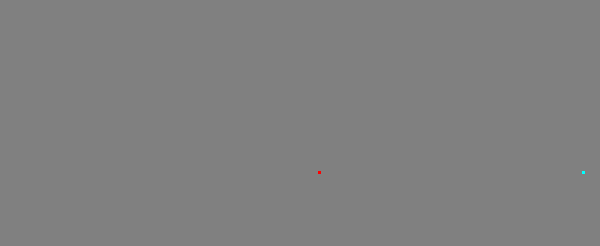

KeyboardInterrupt: ignored

In [58]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gfootball
import gym
import numpy as np
import tensorflow as tf
import random
from collections import deque
import numpy as np
import seaborn as sns
import pandas as pd
import gym
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
from PIL import Image, ImageDraw
from kaggle_environments import make
from tqdm import tqdm
import gym
from typing import Union, Callable, List, Tuple, Iterable, Any, Dict
from google.colab import output

screen_height, screen_width = 84, 200 #[-1, 0.42] and [1, 0.42]

def convert(point):
    return int(point[0] * 100) + 100, int(point[1] * 100) + 42

def lenh(pos1, pos2):
  return ((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def get_reward(obs):
    obs = obs[0]['observation']['players_raw'][0]
    #{'action': [1], 'reward': 0, 'info': {}, 'observation': {'controlled_players': 1, 'players_raw': [{'left_team_yellow_card': [False, False, False, False, False], 'steps_left': 3000, 'left_team': [[-1.0110293626785278, -0.0], [-0.04050014913082123, 0.040464457124471664], [-0.04150555282831192, -0.040772903710603714], [-0.10112815350294113, -0.10154429823160172], [-0.10228612273931503, 0.1027330681681633]], 'ball': [0.0, -0.0, 0.11059734225273132], 'left_team_tired_factor': [0.0, 1.1324882507324219e-05, 4.1604042053222656e-05, 4.827976226806641e-06, 8.32676887512207e-05], 'left_team_roles': [0, 7, 9, 2, 1], 'right_team_roles': [0, 7, 9, 2, 1], 'ball_rotation': [0.0, -0.0, 0.0], 'left_team_direction': [[0.0, -0.0], [-0.00032642309088259935, -0.001039202674292028], [-0.00302221835590899, -0.00031790093635208905], [-0.0001885435194708407, 0.0006234246538951993], [-0.00195687310770154, 0.0018260125070810318]], 'ball_direction': [-0.0, 0.0, -0.0019182914402335882], 'right_team': [[1.0110293626785278, 0.0], [-7.706970478471575e-11, -0.019688168540596962], [-0.0, 0.02032535709440708], [0.10110294073820114, 0.10162678360939026], [0.10110294073820114, -0.10162678360939026]], 'right_team_active': [True, True, True, True, True], 'ball_owned_team': -1, 'score': [0, 0], 'right_team_tired_factor': [0.0, 3.790855407714844e-05, 0.0, 0.0, 0.0], 'game_mode': 0, 'left_team_active': [True, True, True, True, True], 'right_team_yellow_card': [False, False, False, False, False], 'ball_owned_player': -1, 'right_team_direction': [[-0.0, 0.0], [-2.388474140690988e-10, 0.0021058120764791965], [-0.0, 0.0], [-0.0, 0.0], [-0.0, 0.0]], 'designated': 2, 'active': 2, 'sticky_actions': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]}, 'status': 'ACTIVE'}

    #toGoal = lenh(obs['ball'], [1, -0.044]) + lenh(obs['ball'], [1, 0.044]) / 10
    # We always control left team (observations and actions
    # are mirrored appropriately by the environment).
    controlled_player_pos = obs['left_team'][obs['active']]
    if obs['ball'][0] > 0.99:
      if obs['ball'][1] > -0.044 and obs['ball'][1] < 0.044 :
        return 10 #goal
    # Does the player we control have the ball?
    if obs['ball_owned_player'] == obs['active'] and obs['ball_owned_team'] == 0:
        return (controlled_player_pos[0] + 1)/2
    else:
        return - lenh(controlled_player_pos, obs['ball'])

LEFT_PLAYER = 0.8
LEFT_PLAYER_WITH_BALL = 0.5
RIGHT_PLAYER = 0.2
BALL = 1


def get_field(obs):
    obs = obs['observation']['players_raw'][0]
    controlled_player = obs['active']
    ball_owned_player = obs['ball_owned_player']
    ball_owned_team = obs['ball_owned_team']
    ball = obs['ball']
    right_team = obs['right_team']
    left_team = obs['left_team']
    field = np.zeros((screen_width, screen_height))

    for i, player in enumerate(left_team):
      mark = 0
      if controlled_player == i:
         mark = LEFT_PLAYER
      # if ball_owned_player == i and ball_owned_team == 0:
      #   mark = LEFT_PLAYER_WITH_BALL
      point = convert(player)
      field[point[0]][point[1]] = mark

    # for i, player in enumerate(right_team):
    #   mark = RIGHT_PLAYER
    #   point = convert(player)
    #   field[point[0]][point[1]] = mark

    point = convert((ball[0], ball[1]))
    field[point[0]][point[1]] = BALL
    return field

def render(field):
    s = 3
    im = Image.new('RGB', (200*s, 82*s), (128, 128, 128))
    draw = ImageDraw.Draw(im)     
    for x in range(200):
      for y in range(82):
        color = (128, 128, 128)
        if field[x][y] == LEFT_PLAYER:
          color = (255, 0, 0)
        if field[x][y] == RIGHT_PLAYER:
          color = (255, 255, 0)
        if field[x][y] == BALL:
          color = (0, 255, 255)
        if field[x][y] == LEFT_PLAYER_WITH_BALL:
          color = (0, 255, 0)                 
        draw.rectangle(((x-1)*s, (y-1)*s, (x+1)*s, (y+1)*s), fill=color)  
    
    output.clear(output_tags='some_outputs')
    with output.use_tags('some_outputs'):
      display(im)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, screen_height, screen_width, n_actions):
        super(DQN, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(14592, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_actions)

    def forward(self, x): 
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()



# Get number of actions from gym action space
n_actions = 19

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

Left = 1
TopLeft = 2
Top = 3
TopRight = 4
Right = 5
BottomRight = 6
Bottom = 7
BottomLeft = 8
LongPass = 9
HighPass = 10
ShortPass = 11
Shot = 12
Sprint = 13
ReleaseDirection = 14
ReleaseSprint = 15
Slide = 16
Dribble = 17
ReleaseDribble = 18

def getValidMoves(obs):
    obs = obs[0]['observation']['players_raw'][0]

    controlled_player_pos = obs['left_team'][obs['active']]
    actions = np.array(n_actions * [True])
    if controlled_player_pos[0] <= -1 + 0.05:
        actions[1] = False
        actions[2] = False
        actions[8] = False

    if controlled_player_pos[0] >= 1 - 0.05:
        actions[4] = False
        actions[5] = False
        actions[6] = False

    if controlled_player_pos[1] >= 0.42 - 0.05:
        actions[2] = False
        actions[3] = False
        actions[4] = False

    if controlled_player_pos[1] <= -0.42 + 0.05:
        actions[6] = False
        actions[7] = False
        actions[8] = False

    if not (obs['ball_owned_player'] == obs['active'] and obs['ball_owned_team'] == 0): #we don't have ball
        actions[9] = False
        actions[10] = False
        actions[11] = False
        actions[12] = False
        actions[17] = False
        actions[18] = False

    return actions

def select_action(obs, state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    valids = getValidMoves(obs)

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            policy = policy_net(state)
            policy = policy * valids
            return policy.max(1)[1].view(1, 1)

            # x = np.random.choice(n_actions, 1, p=policy[0])
            # return torch.tensor([[x[0]]], device=device, dtype=torch.long)    
            #return policy_net(state).max(1)[1].view(1, 1)
    else:       
        x = np.random.choice(10, n_actions) * valids
        x = x/np.sum(x)          
        x = np.random.choice(n_actions, 1, p=x)
        return torch.tensor([[x[0]]], device=device, dtype=torch.long)
        #return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


def get_state(obs):
    state = get_field(obs[0])
    state = [[state]]
    state = torch.FloatTensor(np.array(state).astype(np.float64))  
    return state.to(device)

env = make("football", configuration={"save_video": True, "scenario_name": "1_vs_1_easy", "running_in_notebook": True})
#env = make("football", configuration={"save_video": False, "scenario_name": "1_vs_1_easy", "running_in_notebook": True})

num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    print('I=', i_episode)  
    obs = env.reset()
    state = get_state(obs)
    for t in count():
        # Select and perform an action
        action = select_action(obs, state)
        
        next_obs = env.step([[action.item()], [0]])
        reward = get_reward(next_obs)

        if t % 10 == 0:
          output.clear(output_tags='rr')
          with output.use_tags('rr'):
              print(t)
              print(reward)
              print(action.item())
              field = get_field(next_obs[0])
              render(field)
              

        next_state = get_state(next_obs)

        reward = torch.tensor([reward], device=device)
        # Observe new state
        if env.done:
            next_state = None
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        obs = next_obs

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if env.done:           
            print(reward)
            print(env)            
            # env.render(mode="human", width=800, height=600)
            episode_durations.append(t + 1)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        torch.save(target_net.state_dict(),  "model")

print('Complete')    

In [42]:
actionSize = 5
actions = np.array(actionSize * [True])
actions[2] = False
actions[3] = False
actions[4] = False

n_actions = 10
x = np.random.choice(10, actionSize) * actions
x = x/np.sum(x)
print(x)
print(np.random.choice(actionSize, 1, p=x))

#torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

[0.25 0.75 0.   0.   0.  ]
[1]
